In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins, utils
#mpld3.enable_notebook()

---

# Molecular graphs

In [4]:
from GArDen.convert.graph import GspanToGraph
from GArDen.interfaces import convert
fname = 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan'
graphs = convert(fname, program=GspanToGraph())

In [5]:
from GArDen.transform.minimal_cycle_annotation import AnnotateMinimalCycles
from GArDen.interfaces import transform
graphs = transform(graphs, program=AnnotateMinimalCycles())

In [6]:
from GArDen.transform.contraction import Minor, contraction_modifier
#reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='sum')
modifier_list = [weight_modifier]
from GArDen.interfaces import transform
priors=dict(nesting=True,  modifiers=[modifier_list], weight_scaling_factor=1)
graphs=transform(graphs, program=Minor(), parameters_priors=priors)

In [7]:
%%time
graphs = list(graphs)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
"GET /~costa/bursi.gspan HTTP/1.1" 200 1207117
CPU times: user 10.3 s, sys: 324 ms, total: 10.6 s
Wall time: 11.1 s


In [8]:
from sklearn.cluster import KMeans
parameters_priors=dict(n_clusters=8, init='k-means++', n_init=10, max_iter=50, tol=0.0001, precompute_distances='auto', verbose=0, random_state=1, copy_x=True, n_jobs=-1)
clusterer = KMeans()

In [15]:
from sklearn.cluster import DBSCAN
parameters_priors=dict(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, random_state=None)
clusterer = DBSCAN()

In [16]:
%%time
from GArDen.interfaces import partition
parameters_priors.update(dict(vectorizer__r=2,vectorizer__d=2, vectorize__n_jobs=-1, vectorize__fit_flag=False, vectorize__n_blocks=5, vectorize__block_size=None))
partition_list = partition(graphs, program=clusterer, parameters_priors=parameters_priors)

CPU times: user 1min 39s, sys: 11.5 s, total: 1min 50s
Wall time: 1min 59s


In [19]:
min_clust_size = 5
max_clust_size = 30
for cluster_id in partition_list:
    clust_size=len(partition_list[cluster_id])
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print 'cluster id: %d size:%d' % (cluster_id, clust_size )

cluster id: 1 size:8
cluster id: 3 size:6
cluster id: 6 size:8
cluster id: 7 size:7
cluster id: 8 size:6
cluster id: 9 size:6
cluster id: 11 size:6
cluster id: 12 size:6
cluster id: 13 size:10
cluster id: 15 size:6
cluster id: 16 size:8
cluster id: 18 size:7


--------------------------------------------------------------------------------
cluster:1 size:8


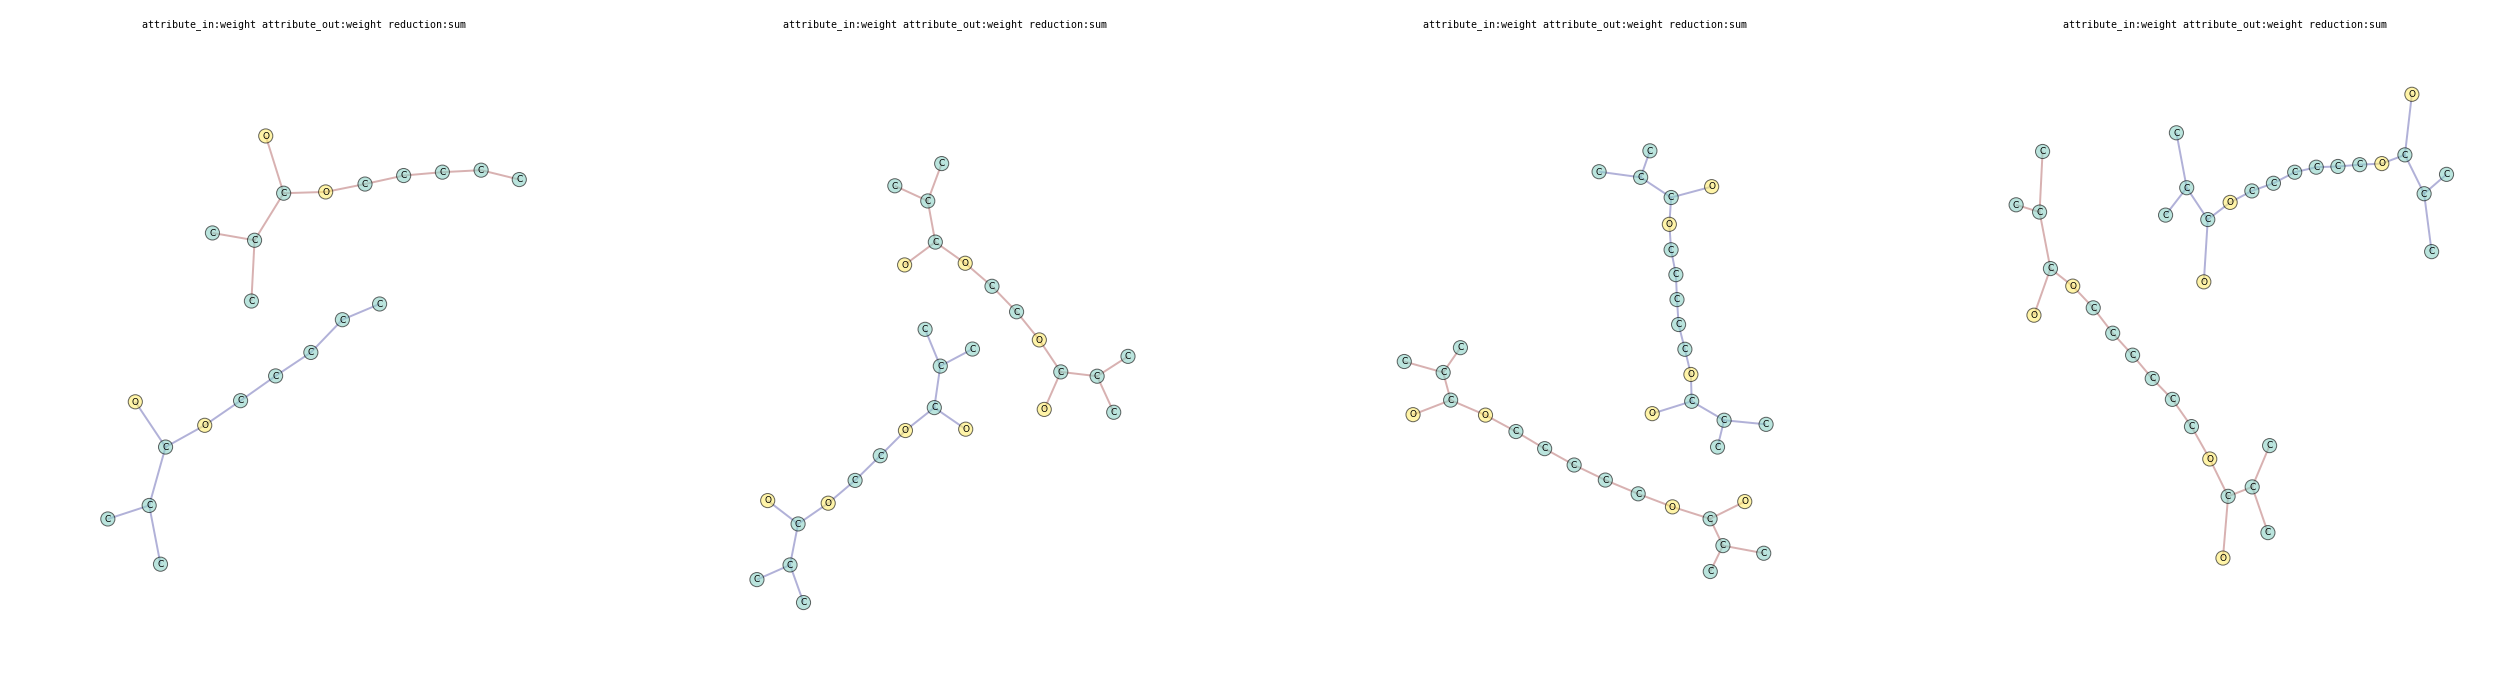

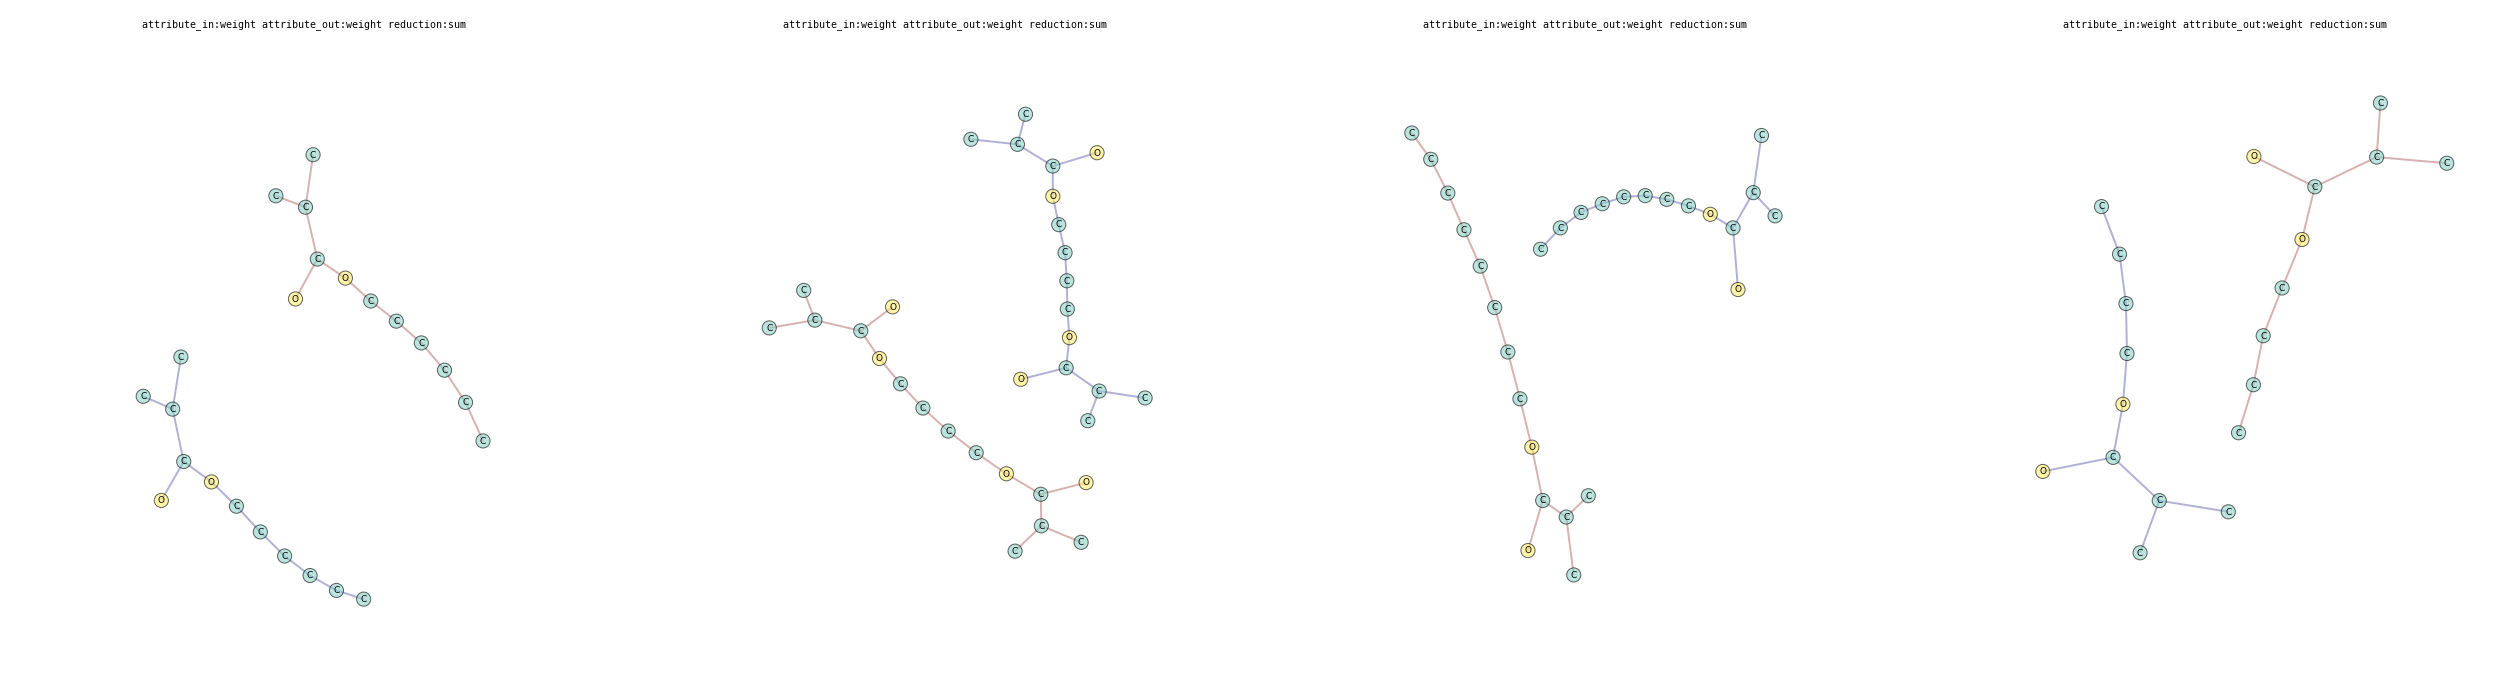

--------------------------------------------------------------------------------
cluster:3 size:6


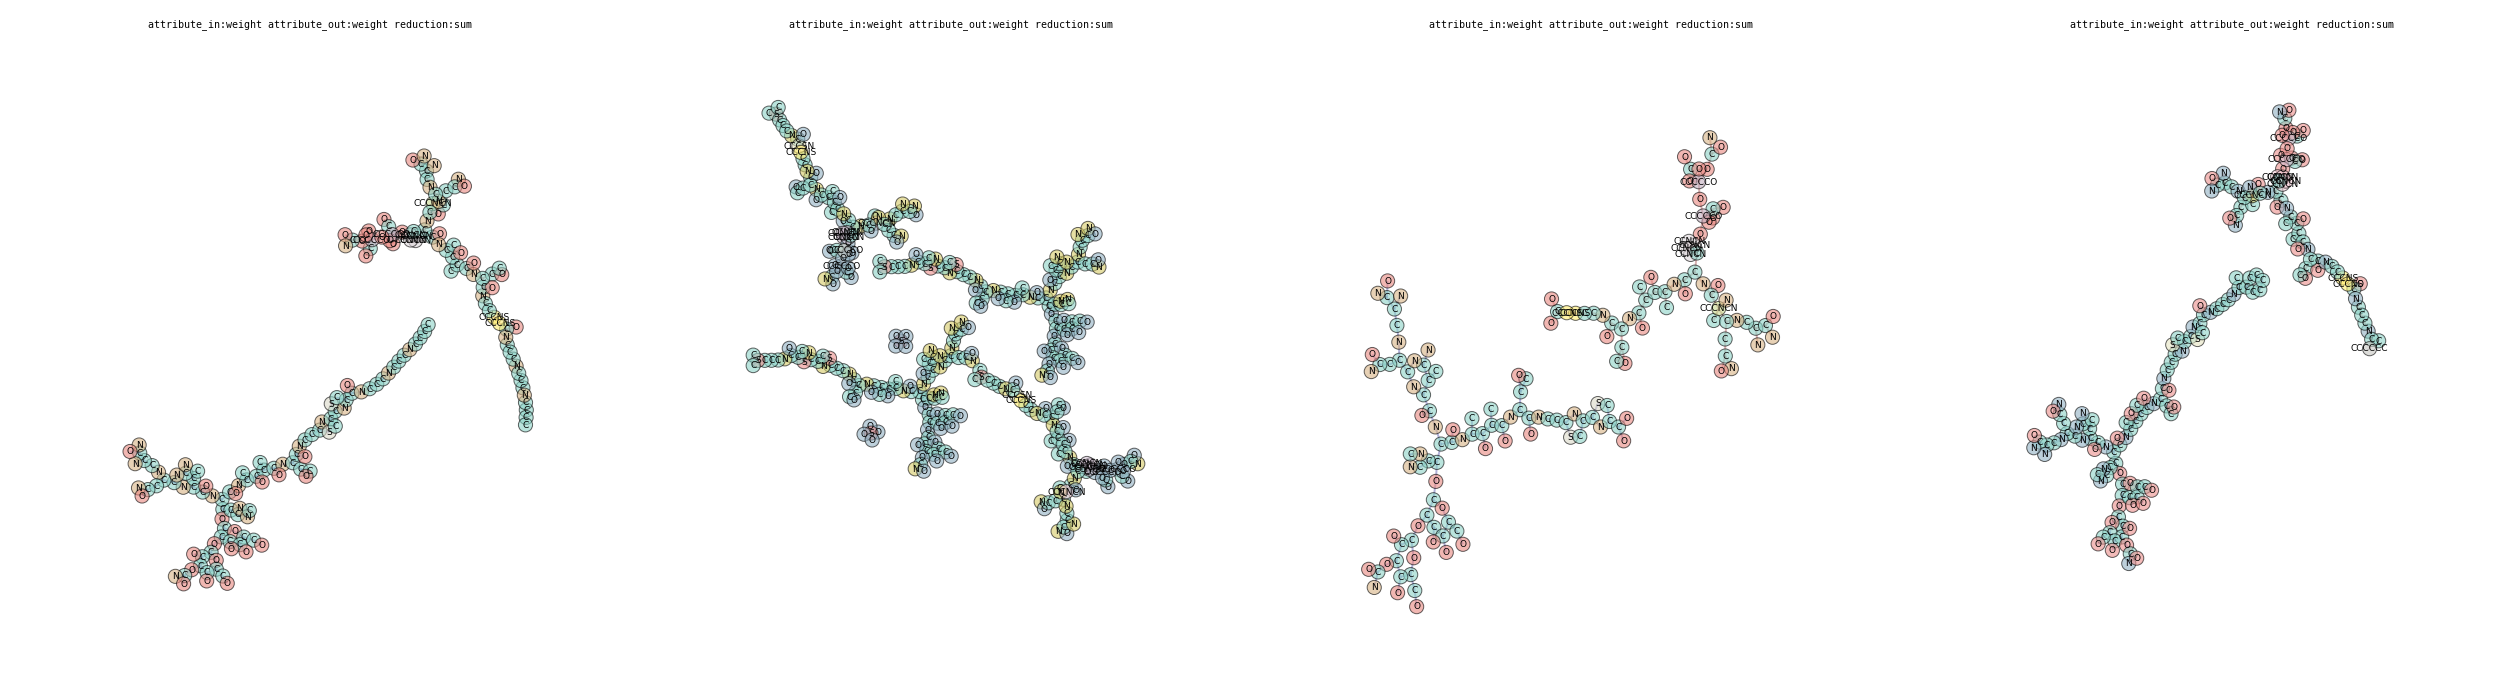

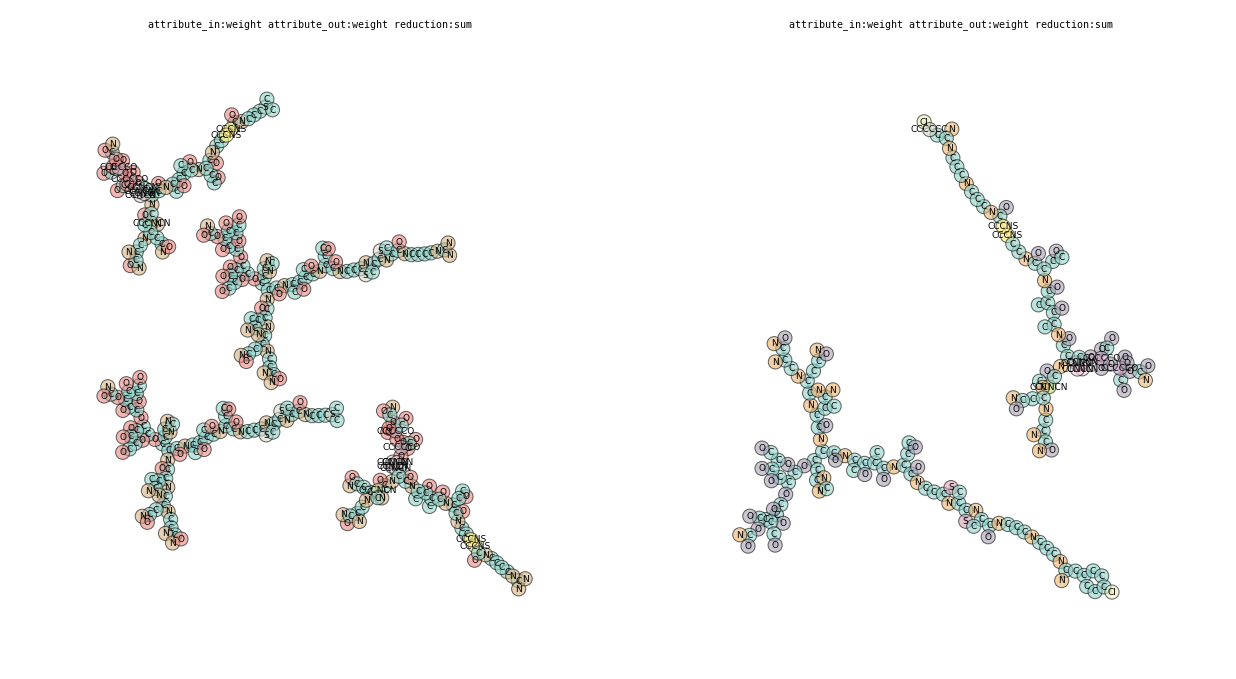

--------------------------------------------------------------------------------
cluster:6 size:8


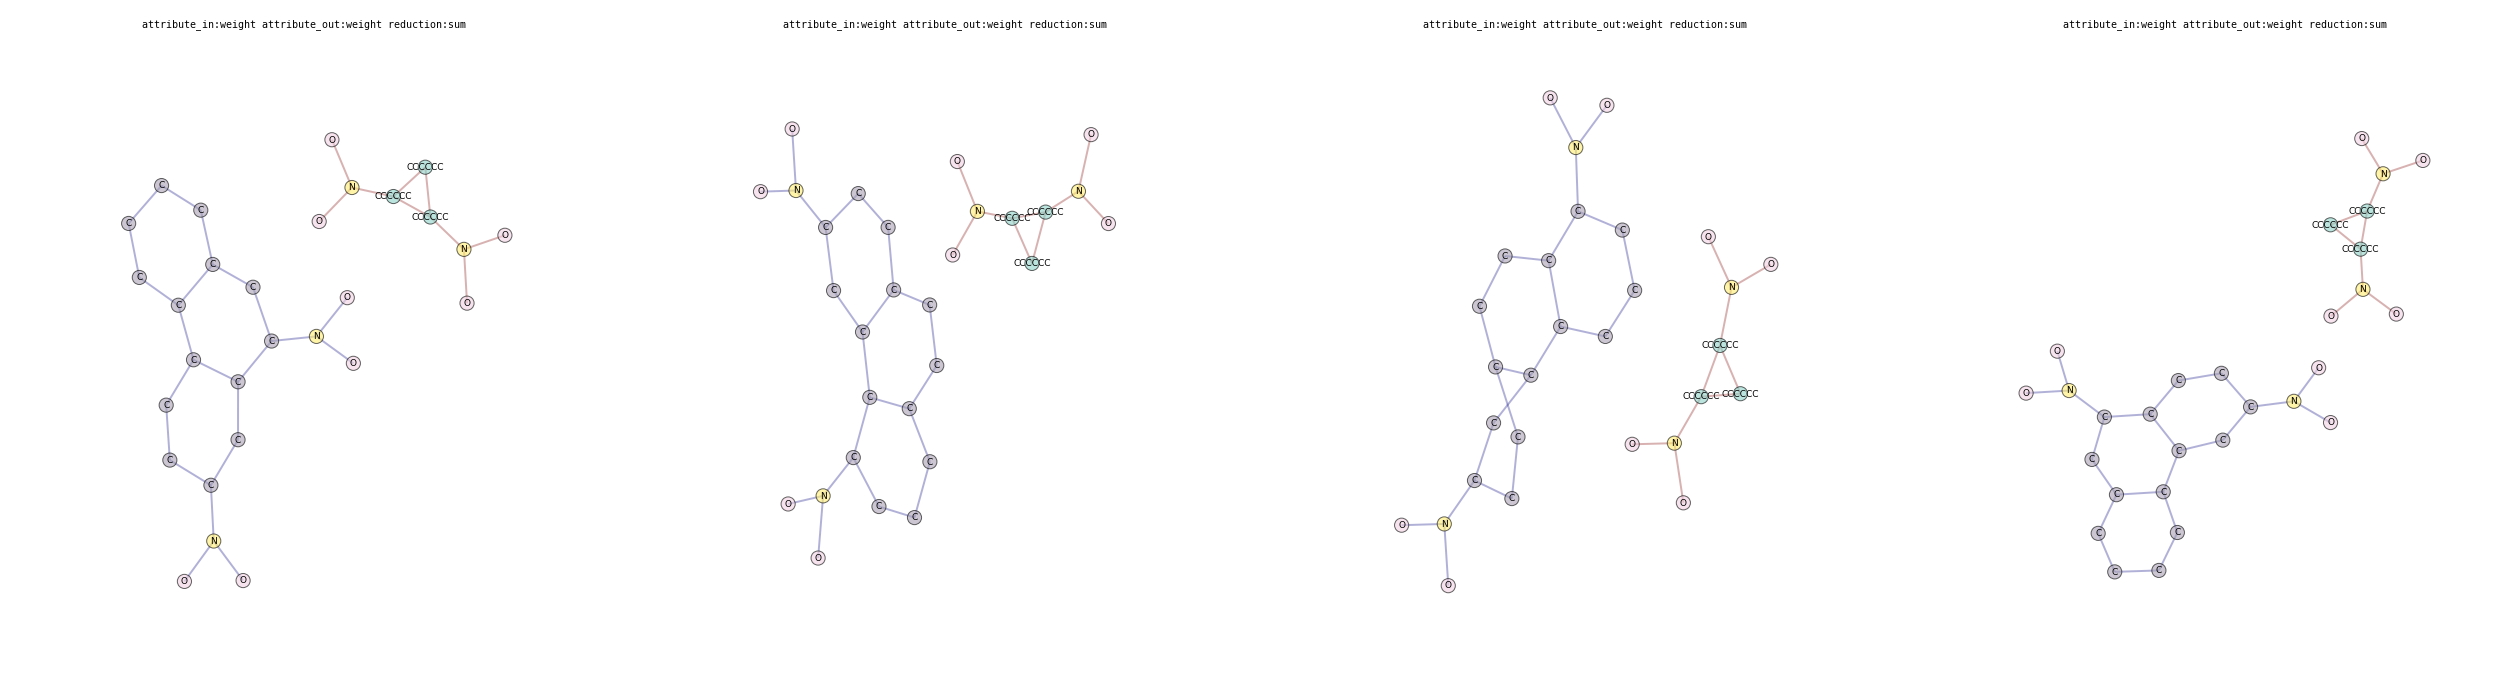

--------------------------------------------------------------------------------
cluster:7 size:7


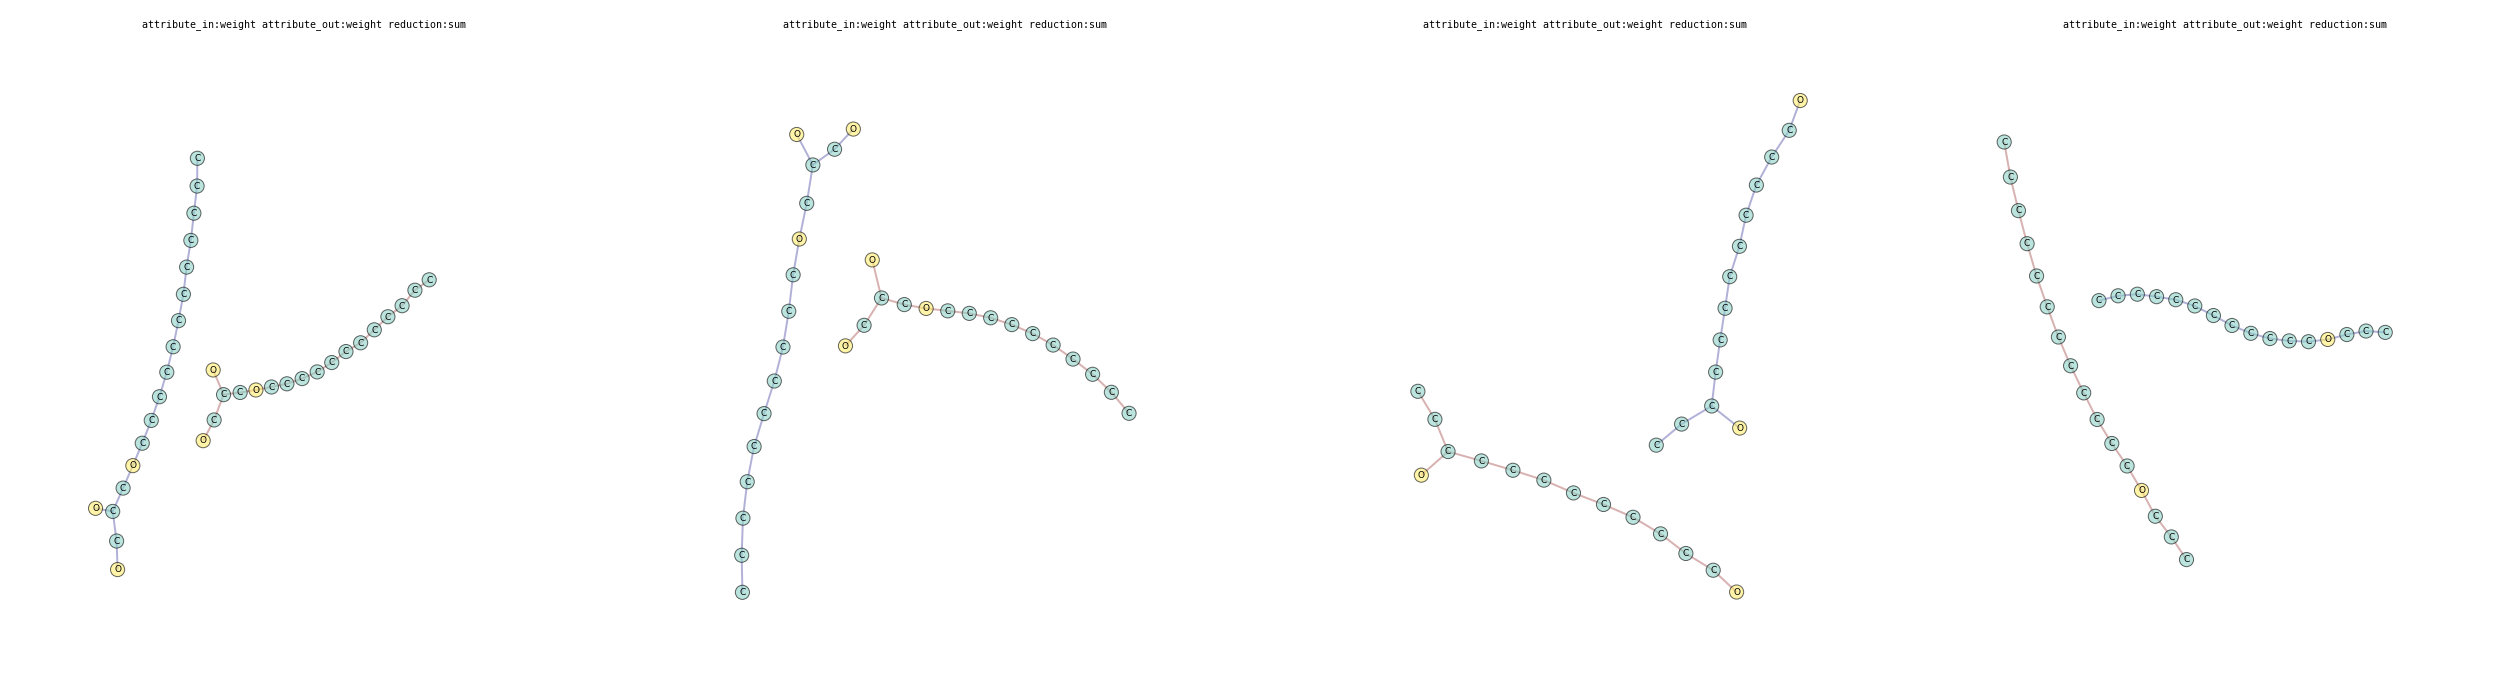

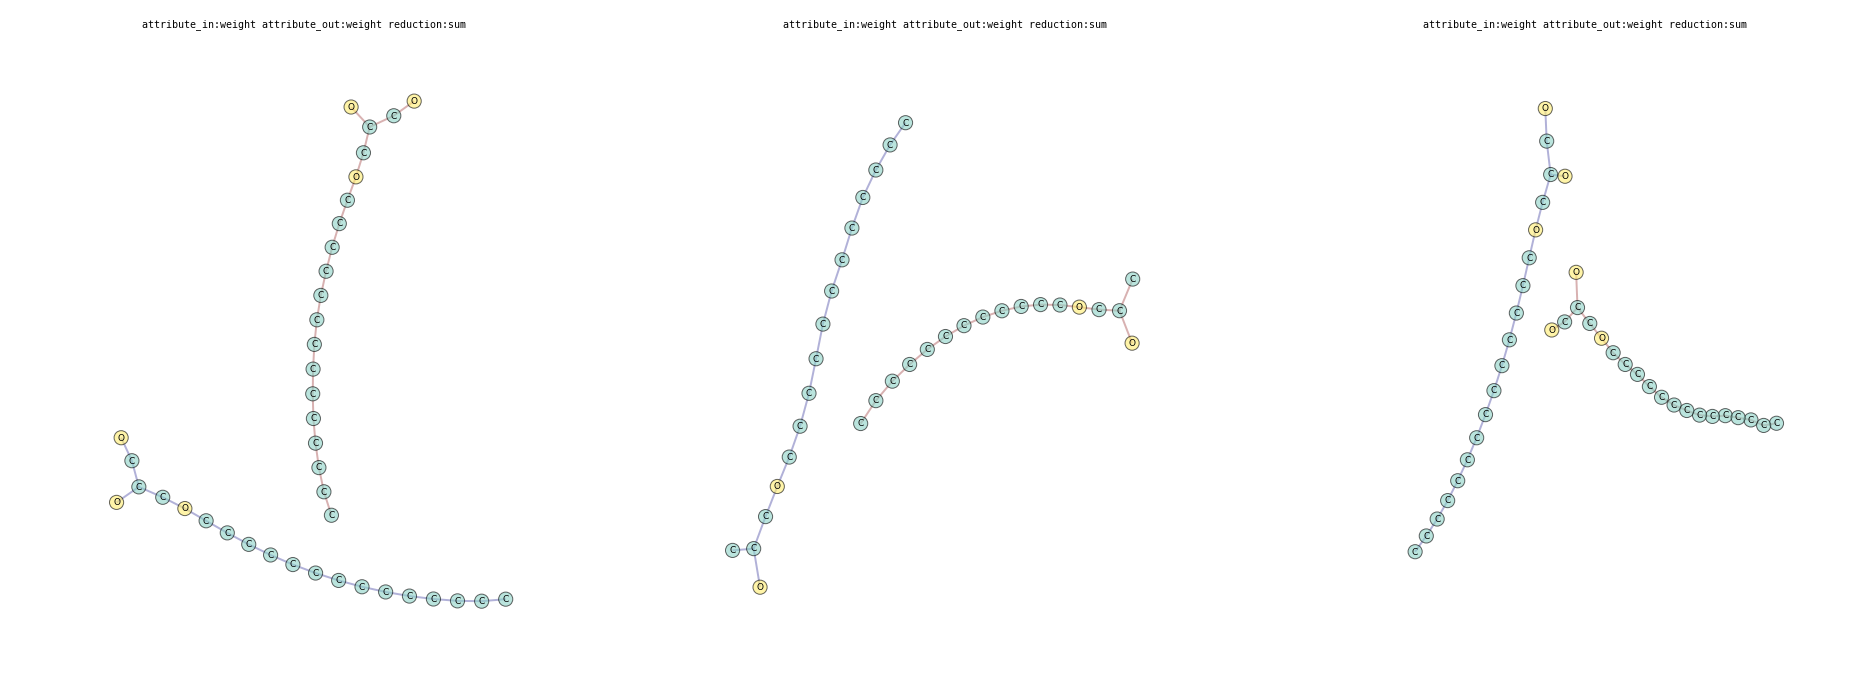

--------------------------------------------------------------------------------
cluster:8 size:6


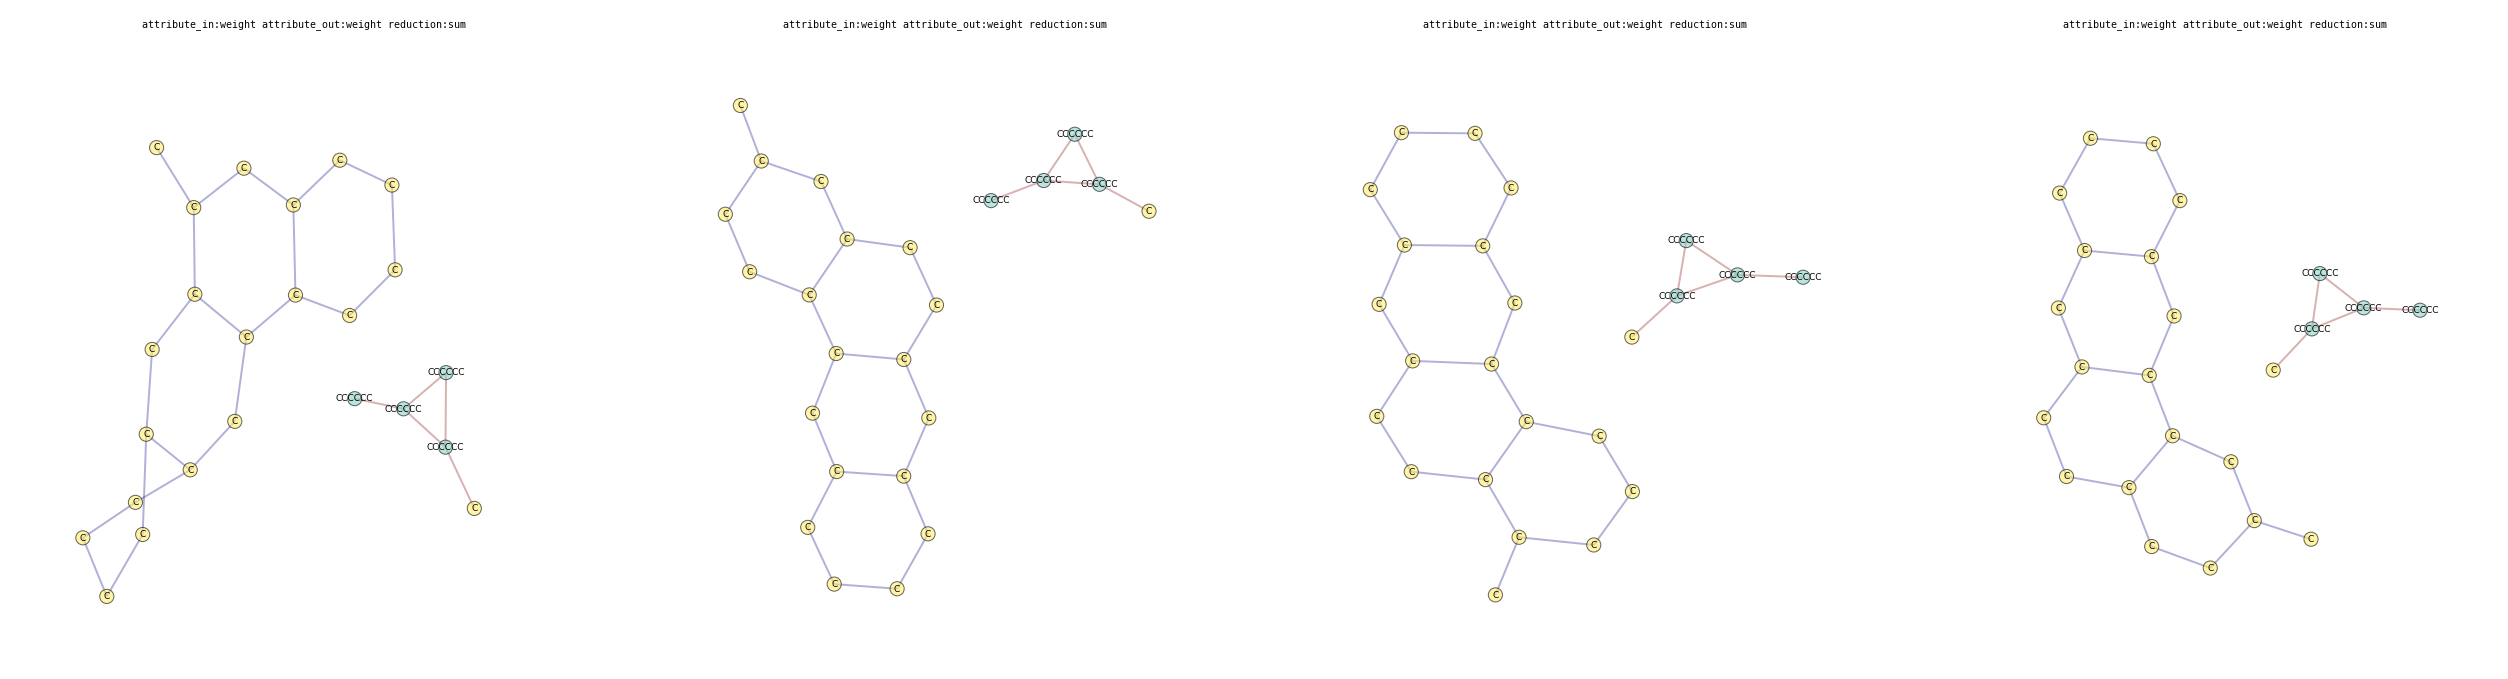

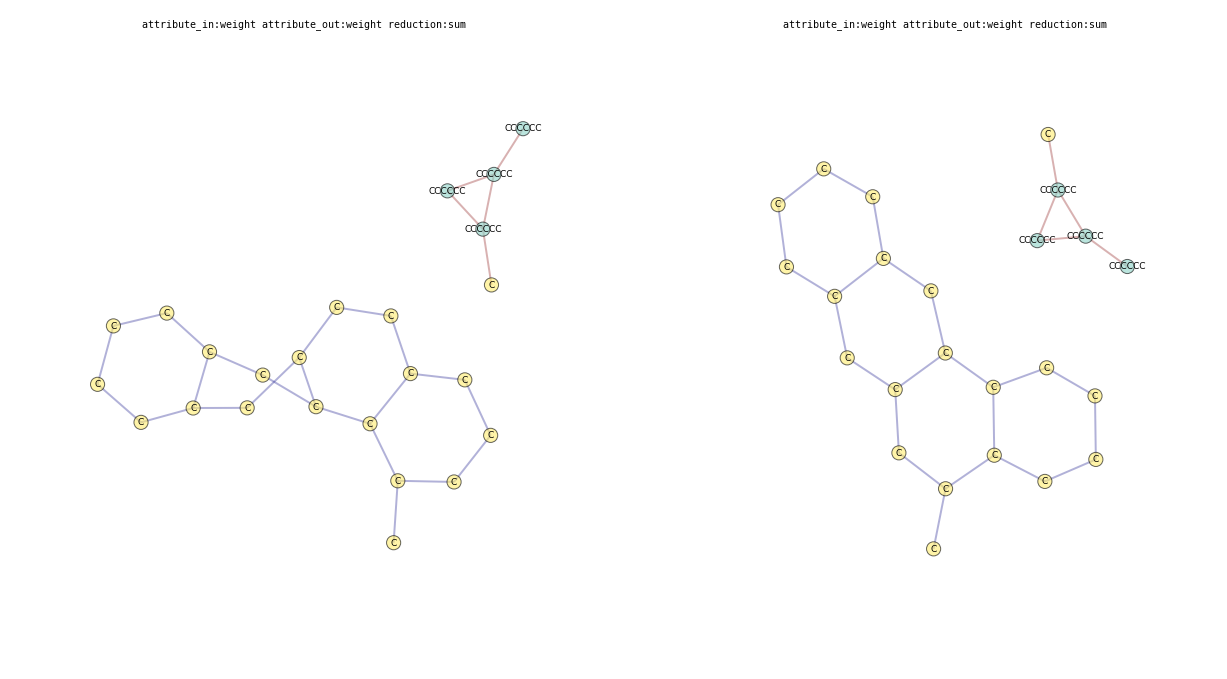

--------------------------------------------------------------------------------
cluster:9 size:6


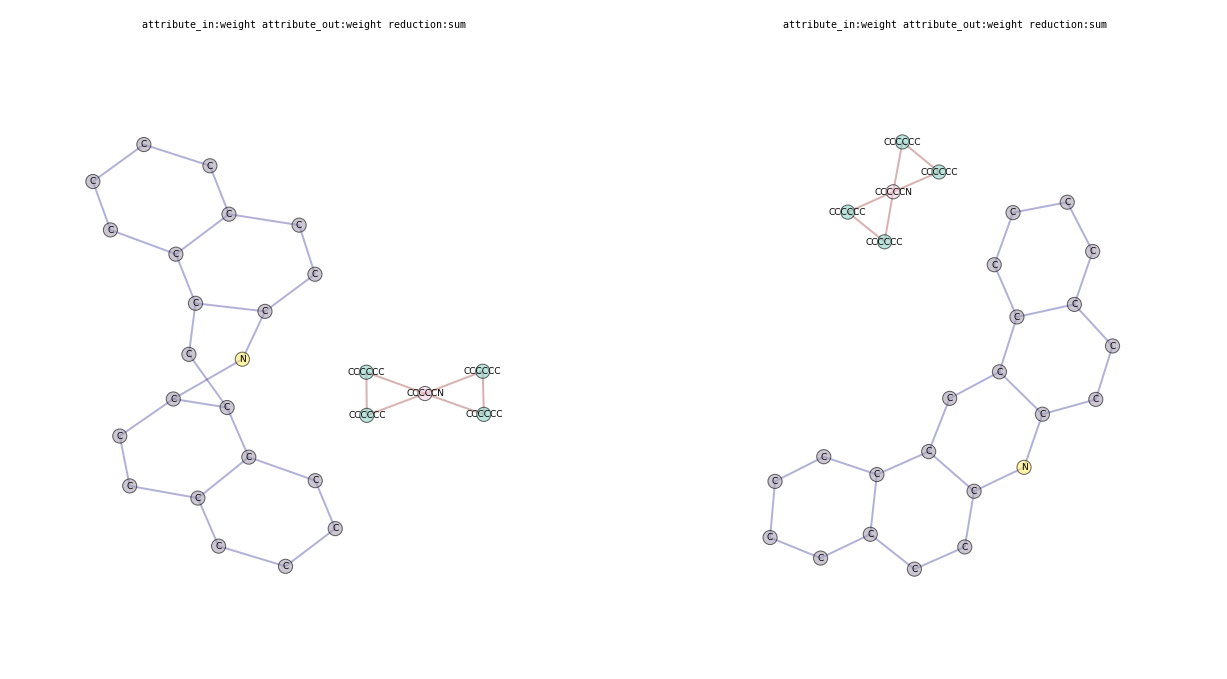

--------------------------------------------------------------------------------
cluster:11 size:6


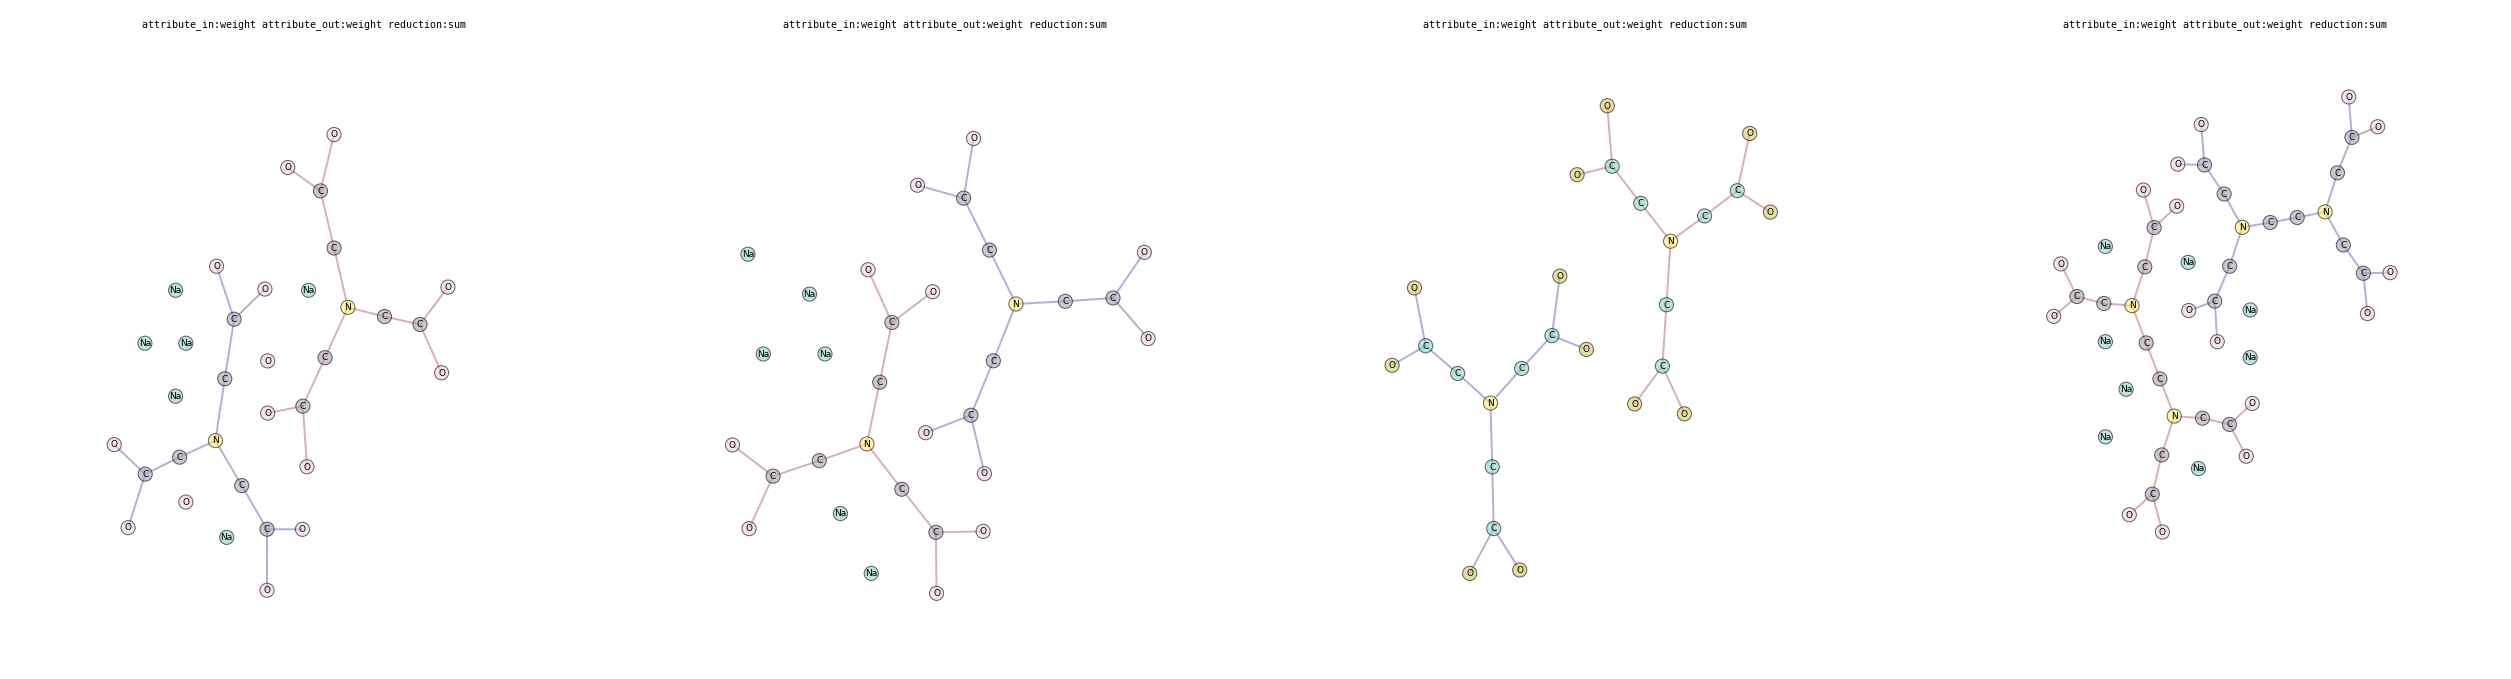

--------------------------------------------------------------------------------
cluster:12 size:6


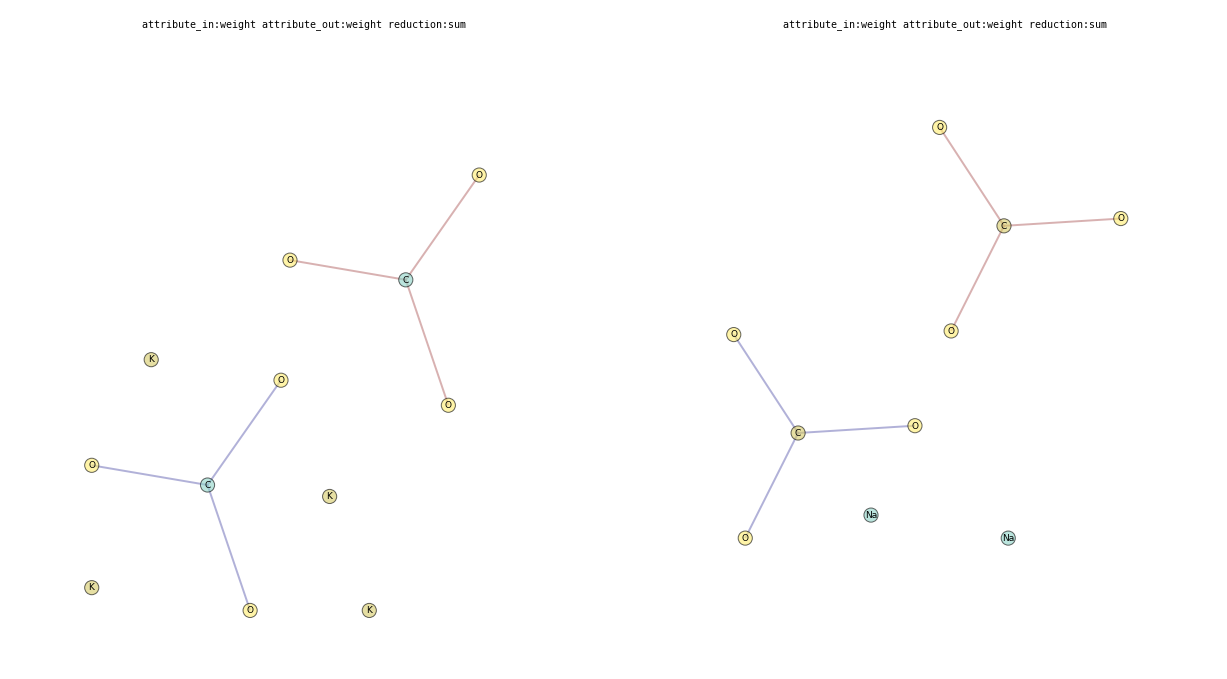

--------------------------------------------------------------------------------
cluster:13 size:10


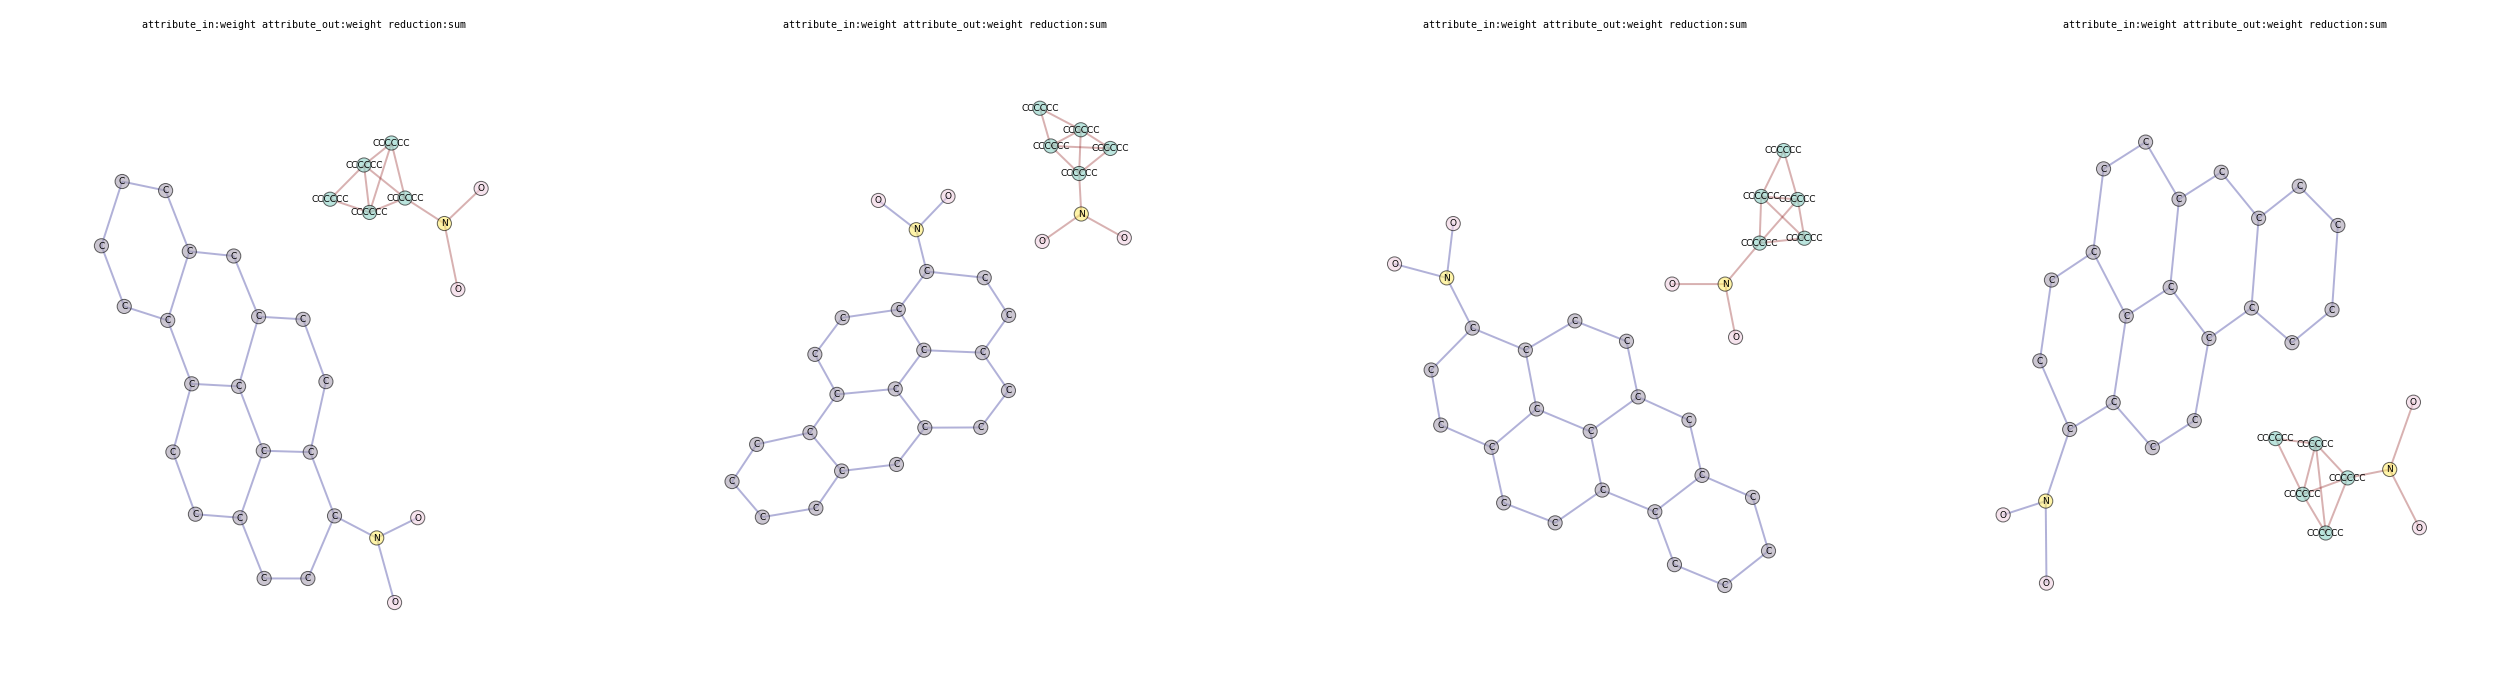

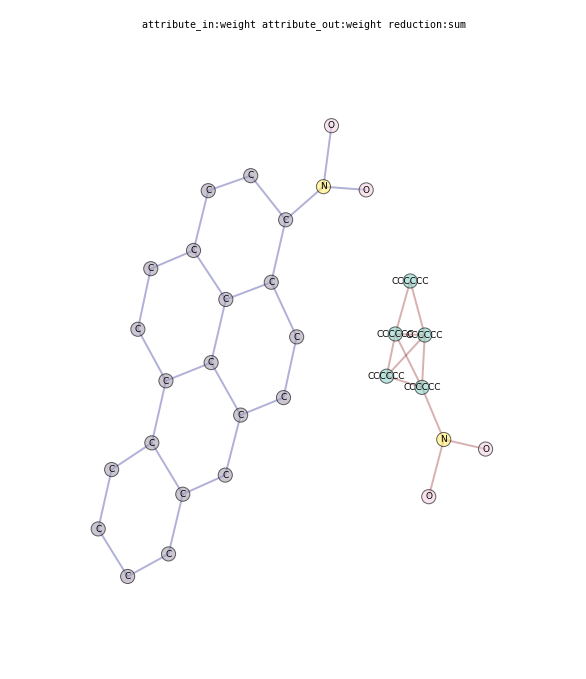

--------------------------------------------------------------------------------
cluster:15 size:6


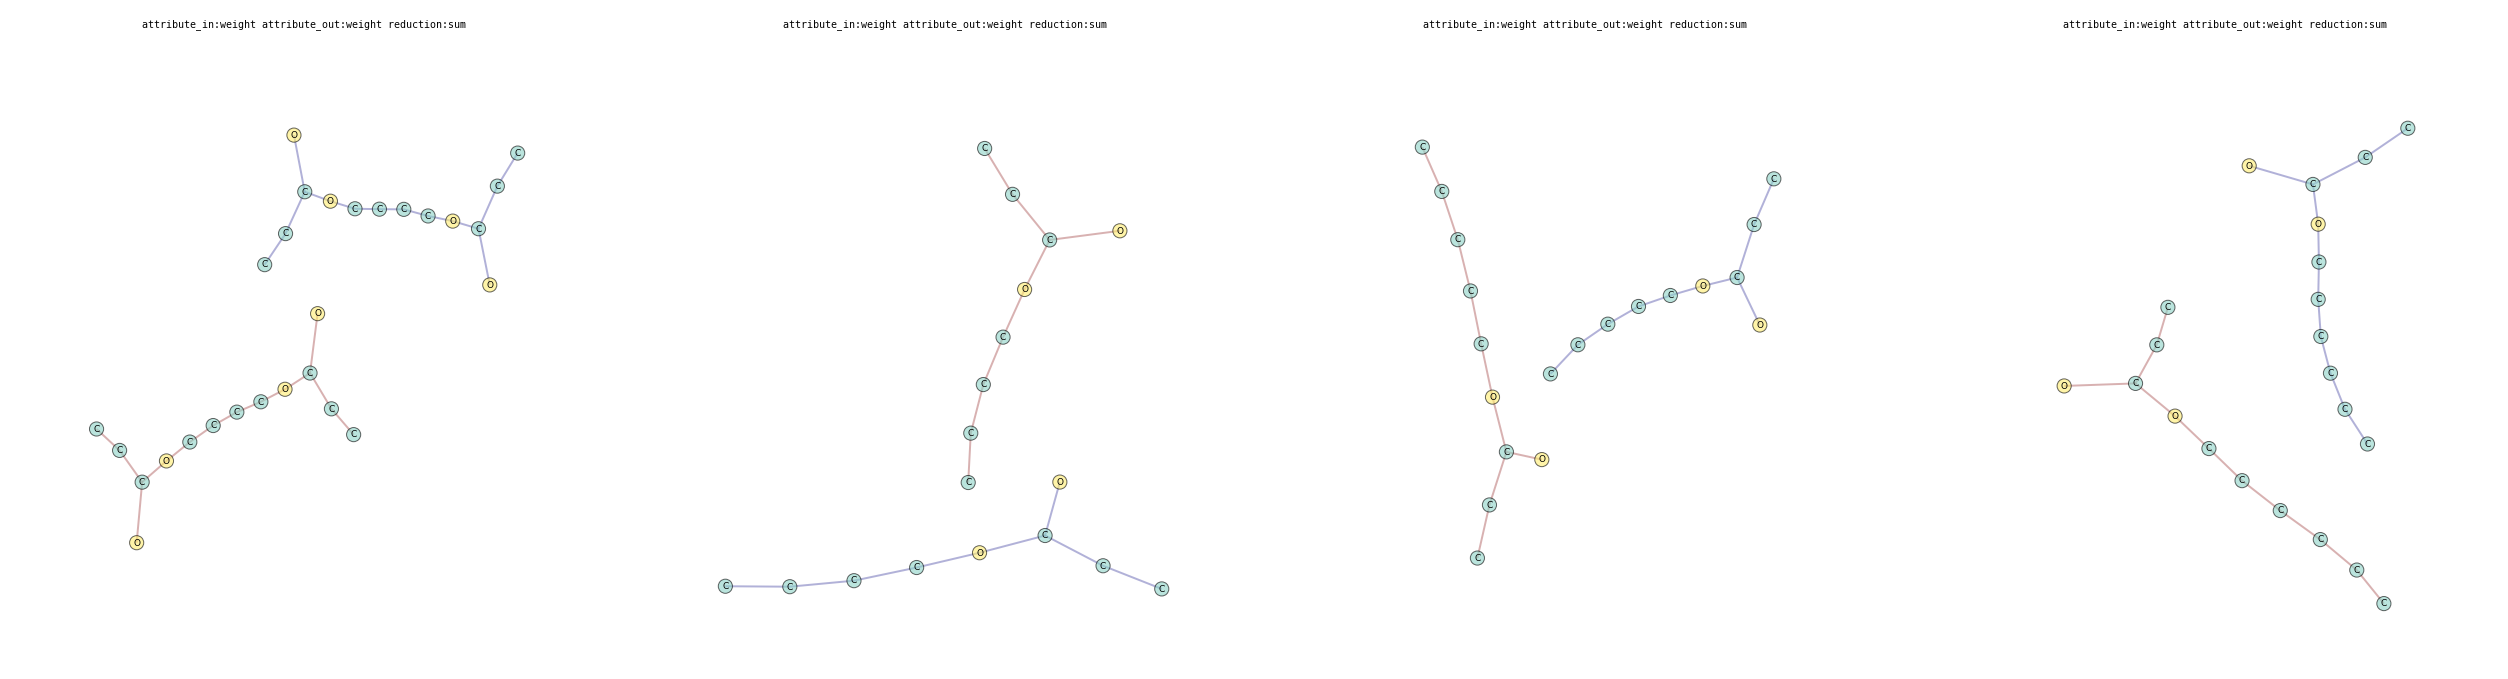

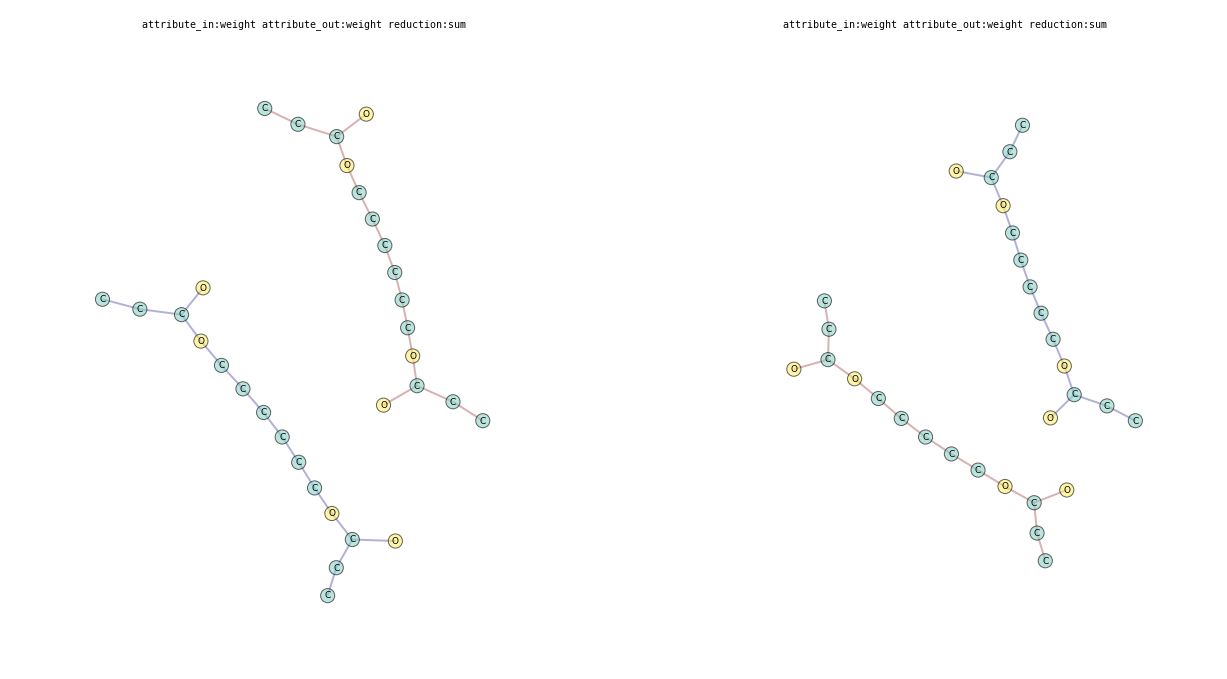

--------------------------------------------------------------------------------
cluster:16 size:8


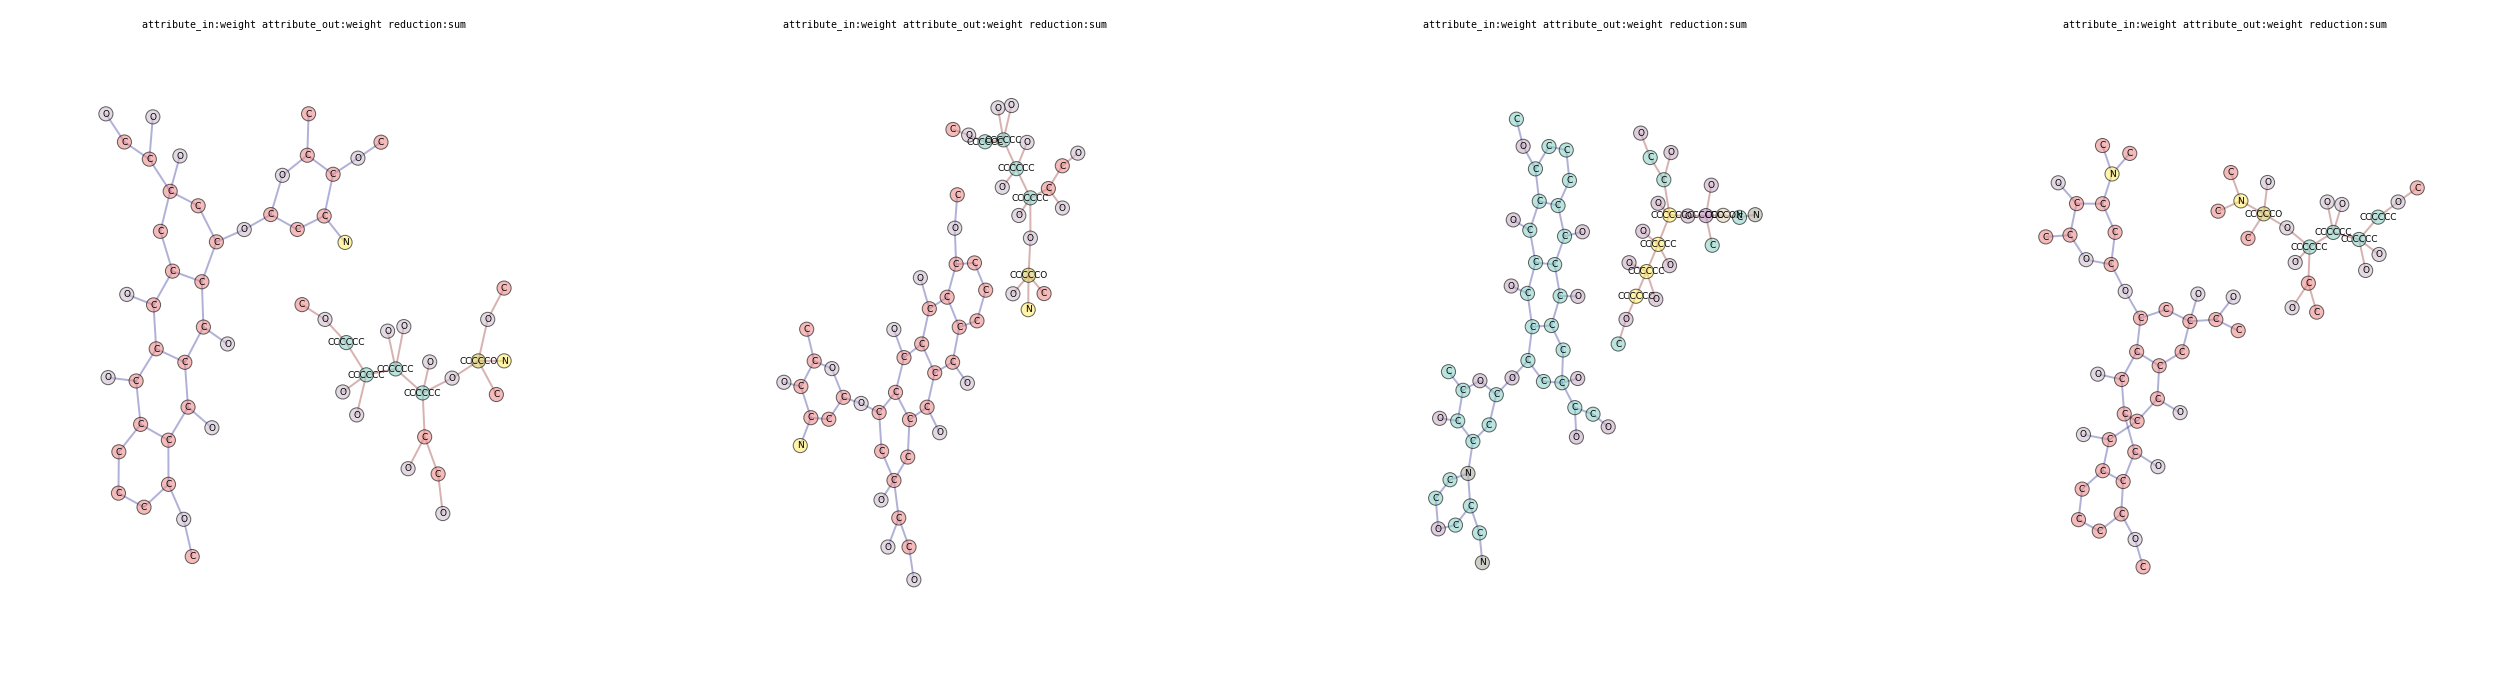

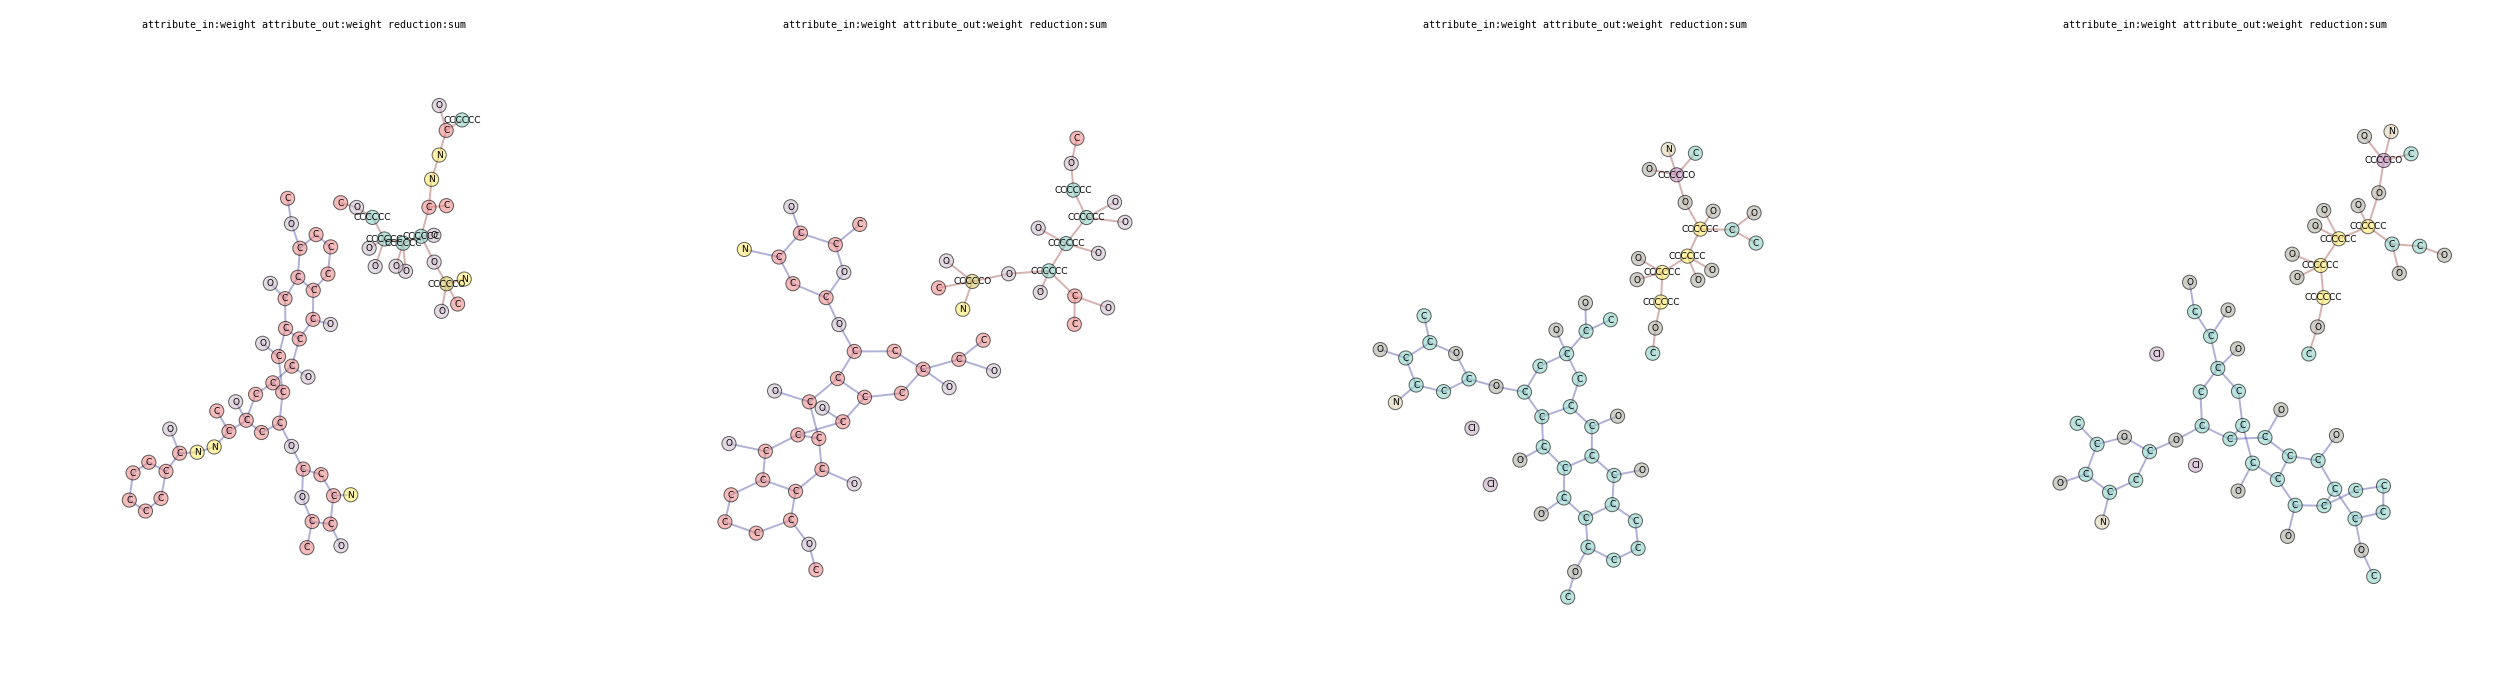

--------------------------------------------------------------------------------
cluster:18 size:7


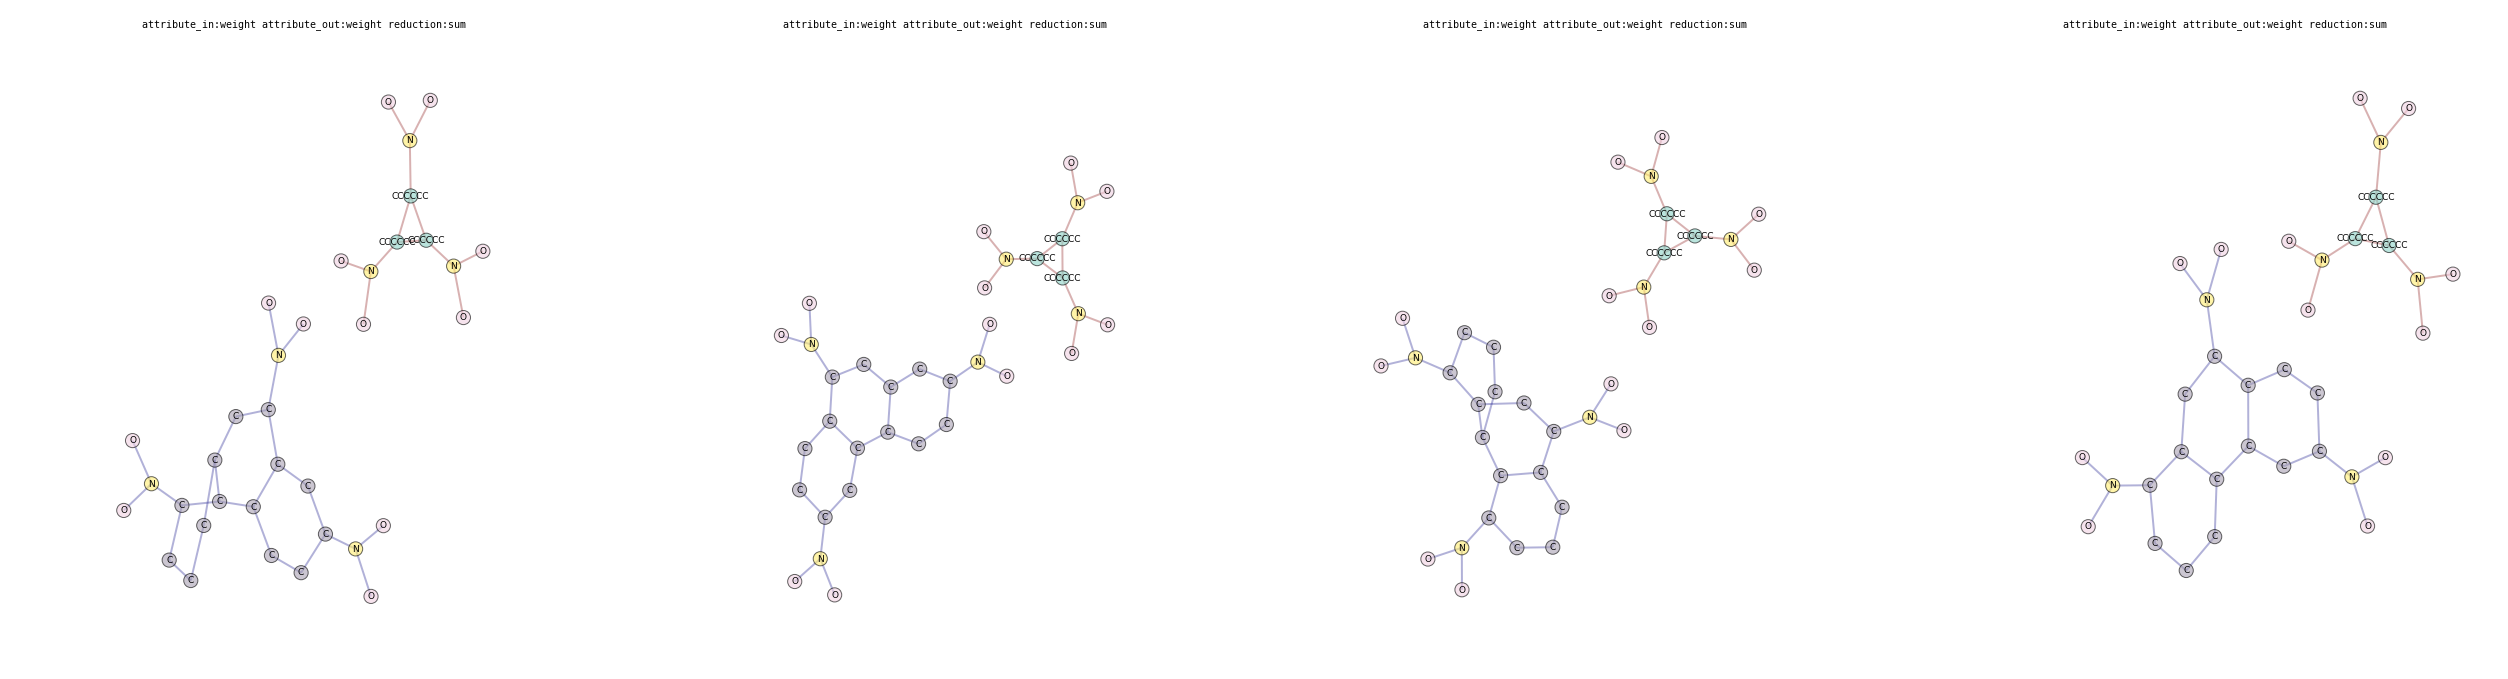

In [20]:
from GArDen.transform import DeleteEdge
n_graphs_per_line = 3
max_n_examples_drawn_per_cluster = n_graphs_per_line*3

from itertools import islice
from eden.util.display import draw_graph_set
for cluster_id in partition_list:
    clust_size = len(partition_list[cluster_id])
    if clust_size > min_clust_size and clust_size < max_clust_size:
        print '-'*80
        print 'cluster:%d size:%d' % (cluster_id, clust_size)
        clustered_graphs = islice(partition_list[cluster_id], max_n_examples_drawn_per_cluster) 
        clustered_graphs = transform(clustered_graphs,program=DeleteEdge(), parameters_priors=dict(attribute='nesting',value=True))
        draw_graph_set(clustered_graphs, n_graphs_per_line=4, size=11, title_key='info', prog='neato', node_border=1, node_size=200, colormap='Set3',
                   edge_color='_label_',edge_alpha=.3, vertex_label='label', vertex_color='_label_', ignore_for_layout='nesting')

---